In [30]:
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys

import random

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, "data")
dir = os.path.join(data_dir, "SPST_perfect")

In [38]:
file = loadmat(os.path.join(dir, "SPSTdata_2_pol-60.mat"))

maps = file["AcombineAll"][0]
X = file["Xnom_dumARRAY"][0]
Y = file["Ynom_dumARRAY"][0]

len_map = 26
len_map_big = 10

forbiden = [196, 197, 216, 217, 236, 237, 251, 255, 256, 262, 276, 277, 297, 317]
ind_forbiden = []

coords = []
for l in range(len(X)):
    # ignore the additional values in the center
    if X[l] not in forbiden and Y[l] not in forbiden:
        coords.append((X[l], Y[l]))
    else:
        ind_forbiden.append(l)

# remove the maps corresponding to the forbiden indices
maps = np.delete(maps, ind_forbiden, axis=0)

In [40]:
from scipy.io import loadmat

file = loadmat(os.path.join(data_dir, "final_data_head.mat"))

cal_grid = file['cal_grid']
inter_grid = file['inter_grid']
SPST_calib = file['SPST_calib'] # en fait, c'est les fpsts

In [204]:
spsts_theory = np.load(os.path.join(data_dir, "final_data_theory.npy"))
spsts_pred = np.load(os.path.join(data_dir, "final_data_pred.npy"))

In [207]:
spsts_theory[1024]

array([[6.30454409e-08, 6.67059368e-08, 6.97473297e-08, ...,
        1.90107396e-08, 1.90133758e-08, 1.76135462e-08],
       [6.23655367e-08, 6.45689795e-08, 6.69381990e-08, ...,
        1.77769053e-08, 1.85387545e-08, 1.81832114e-08],
       [6.03636252e-08, 6.30191508e-08, 3.35699823e-08, ...,
        1.81695317e-08, 1.83818827e-08, 1.83094997e-08],
       ...,
       [1.20168240e-08, 1.22775736e-08, 1.16965069e-08, ...,
        1.19413599e-08, 1.09004183e-08, 1.25585577e-08],
       [1.21205801e-08, 1.17629551e-08, 1.06406626e-08, ...,
        1.23967840e-08, 1.12356835e-08, 1.20166641e-08],
       [1.20319523e-08, 1.13190426e-08, 1.04988915e-08, ...,
        1.19406307e-08, 1.17310348e-08, 1.26174964e-08]])

In [199]:
print(np.mean(spsts_theory) / np.mean(spsts_pred))

1.8523813301765004


In [189]:
def null_disc(map, c):
    i, j = c.astype(int)
    for x in range(i - 20, i + 20):
        for y in range(j - 20, j + 20):
            if x < 0 or y < 0 or x >= 512 or y >= 512:
                continue
            if (x - i) ** 2 + (y - j) ** 2 <= 100:
                map[x][y] = 0
    return map

In [202]:
len_map_big = 512

map_theory = np.zeros((len_map_big, len_map_big))
map_pred = np.zeros((len_map_big, len_map_big))

grid = inter_grid

right_coords = []
indexes = []
for i in range(len(grid)):
    c = grid[i]
    if c[0] > len_map_big / 2:
        right_coords.append(c)
        indexes.append(i)

right_coords = np.array(right_coords)
indexes = np.array(indexes)

# select the right spsts
right_fpsts_theory = spsts_theory[indexes]
right_fpsts_pred = spsts_pred[indexes]

# for each fpst in the right side, add it to the map
for i in range(len(right_fpsts)):
    # set a 20 radius disc around (i,j) to 0
    map_theory += null_disc(right_fpsts_theory[i], right_coords[i])
    map_pred += null_disc(right_fpsts_pred[i], right_coords[i])

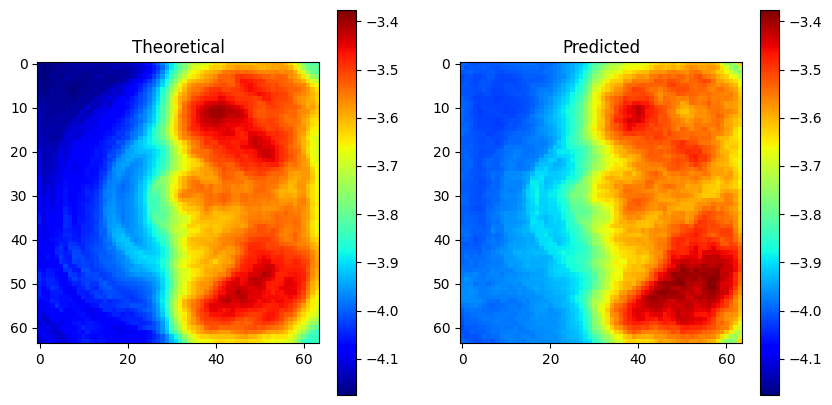

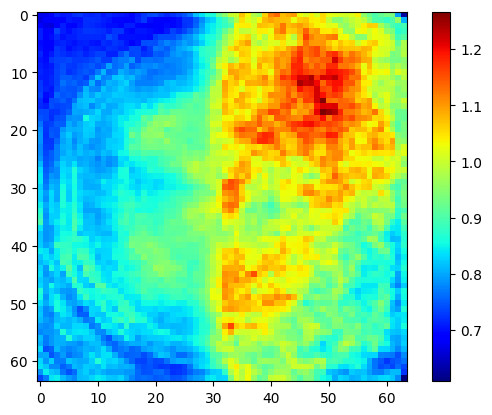

Error: 0.10480571767795326


In [203]:
# apply binning 8x8 to the maps
map_theory_ = map_theory.reshape((64, 8, 64, 8)).mean(3).mean(1)
map_pred_ = np.multiply(map_pred, 1.8)
map_pred_ = map_pred_.reshape((64, 8, 64, 8)).mean(3).mean(1)

# display the maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

vmin = np.min([np.min(np.log10(map_theory_)), np.min(np.log10(map_pred_))])
vmax = np.max([np.max(np.log10(map_theory_)), np.max(np.log10(map_pred_))])

ax1.imshow(np.log10(map_theory_), cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_title("Theoretical")
ax2.imshow(np.log10(map_pred_), cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_title("Predicted")

# Add a colorbar to the plot to show the scale
fig.colorbar(ax1.imshow(np.log10(map_theory_), cmap='jet', vmin=vmin, vmax=vmax), ax=ax1)
fig.colorbar(ax2.imshow(np.log10(map_pred_), cmap='jet', vmin=vmin, vmax=vmax), ax=ax2)

plt.show()

map_ratio = map_theory_ / map_pred_

# display the ratio
plt.imshow(map_ratio, cmap='jet')
plt.colorbar()
plt.show()

# compute the error
error = np.sum(np.abs(map_theory_ - map_pred_)) / np.sum(map_theory_)
print(f"Error: {error}")

In [150]:
def get_center(map):
    max_sum = 0
    nom_i = 0
    nom_j = 0
    max = np.max(map)
    coord = np.where(map == max)
    i_m = coord[0][0]
    j_m = coord[1][0]
    for i in range(i_m - 2, i_m + 2):
        for j in range(j_m - 2, j_m + 2):
            if i < 0 or j < 0 or i >= 512 or j >= 512:
                continue
            sum = np.sum(map[i : i + 2, j : j + 2])
            if sum > max_sum:
                max_sum = sum
                nom_i = i
                nom_j = j
    return (nom_i, nom_j, max_sum)

In [182]:
def compute_stray_light(map):
    i, j, nominal = get_center(map)
    #map = map / nominal

    # set a 20 radius disc around (i,j) to 0
    map = null_disc(map, np.array([i, j]))
    return np.sum(map)

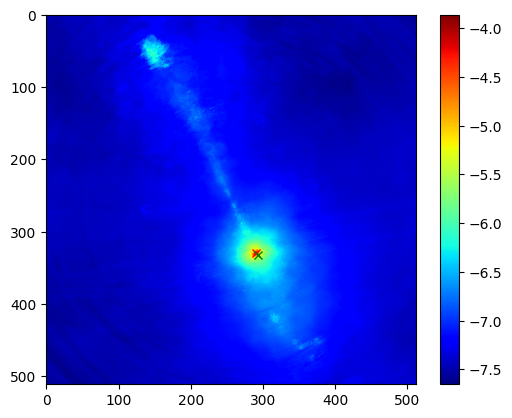

In [170]:
ind = random.randint(0, len(spsts_theory) - 1)

map = spsts_pred[ind]
x, y, _ = get_center(map)
i, j = inter_grid[ind]

#map[x - 10 : x + 10, y - 10: y + 10] = 0

plt.imshow(np.log10(map), cmap='jet')
plt.plot(y, x, 'x', color='red')
plt.plot(i, j, 'x', color='green')
plt.colorbar()
plt.show()

In [191]:
elevations = []
sl_list_theory = []
sl_list_pred = []
x_list = []
y_list = []

for i in range(len(spsts_theory)):
    sl_theory  = compute_stray_light(spsts_theory[i])
    sl_pred = compute_stray_light(spsts_pred[i])

    x, y = inter_grid[i]
    x = int(x)
    y = int(y)

    r = np.sqrt((x - 256) ** 2 + (y - 256) ** 2)

    x_list.append(x)
    y_list.append(y)
    elevations.append(r)
    sl_list_theory.append(sl_theory)
    sl_list_pred.append(sl_pred)

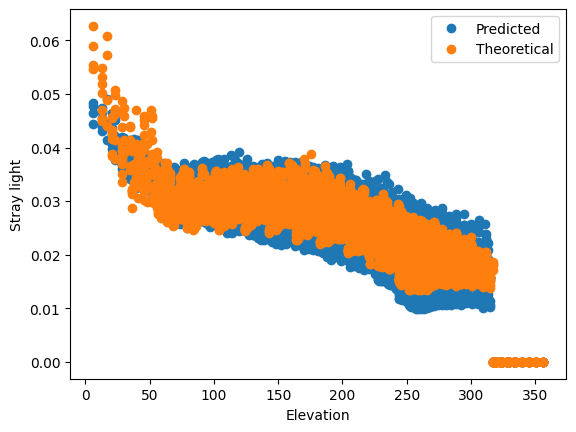

In [192]:
# plot the stray light as a function of the elevation
plt.plot(elevations, np.multiply(sl_list_pred, 1.8), 'o', label="Predicted")
plt.plot(elevations, sl_list_theory, 'o', label="Theoretical")
plt.xlabel("Elevation")
plt.ylabel("Stray light")
plt.legend()
plt.show()

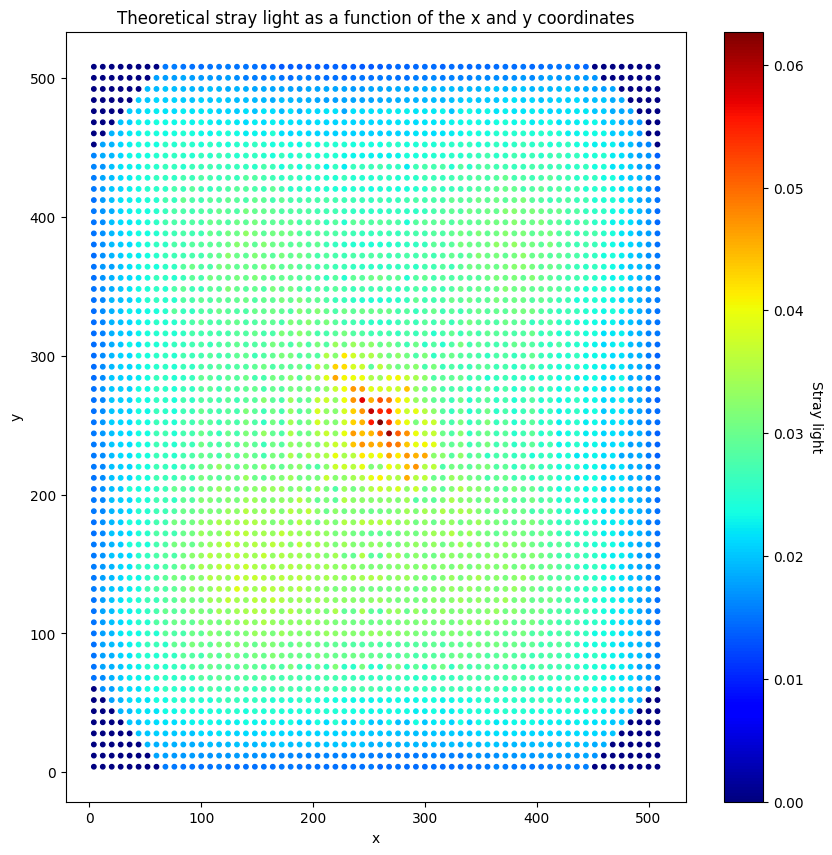

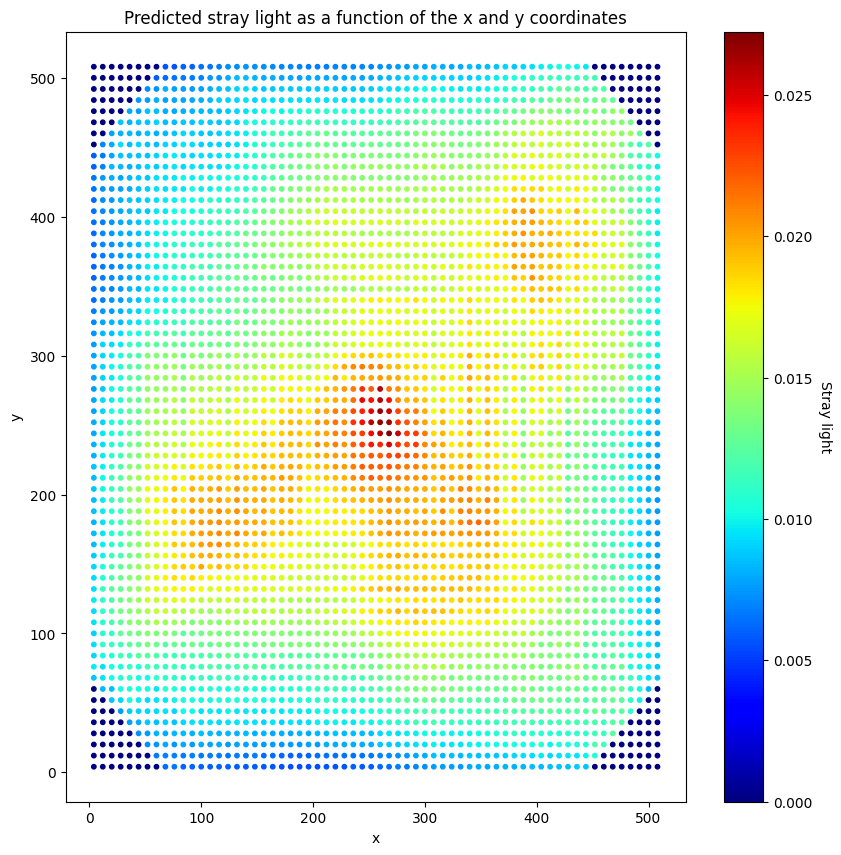

In [193]:
# scatter plot the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x_list, y_list, c=sl_list_theory, s=10, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Theoretical stray light as a function of the x and y coordinates')
# add a scaled colorbar
cbar = ax.figure.colorbar(ax.collections[0], ax=ax)
cbar.ax.set_ylabel('Stray light', rotation=-90, va="bottom")
plt.show()

# scatter plot the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x_list, y_list, c=sl_list_pred, s=10, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Predicted stray light as a function of the x and y coordinates')
# add a scaled colorbar
cbar = ax.figure.colorbar(ax.collections[0], ax=ax)
cbar.ax.set_ylabel('Stray light', rotation=-90, va="bottom")
plt.show()